<a href="https://colab.research.google.com/github/Anup8777/TensorFlow_DeepLearning/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## CNN for MNIST dataset

The MNIST dataset is not a complecated dataset with images of RGB values. It does not require a super deep or a deep CNN for classification of digits. The simple CNN with one layer 32 filters of stride 2 with Relu activation and one output layer with a Softmax activation gives us a descent accuracy. 

The filters, the filter layers, the stride and the pooling size are the some of the very important factors that affect the performance of the CNN. However, this does not mean that the other factors do not play an important role.

The filters and the pooling layers play a more prominent role than the non linear layers in the CNN, which is unlike in MLPs or Feed Forward Networks.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers as layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import tensorboard
import datetime
import warnings
import os
from sklearn import metrics
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10, cifar100
import numpy as np
import os

%load_ext tensorboard

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
logdir = os.path.join("logs", datetime.datetime.now( ).strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
warnings.filterwarnings('ignore')

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_rows = x_train[0].shape[0]
img_cols = x_test[0].shape[1]
no_channels = 1
BATCH_SIZE = 128
EPOCHS = 30

x_train = x_train.reshape(x_train.shape[0],img_rows,img_cols,no_channels)
x_test = x_test.reshape(x_test.shape[0],img_rows,img_cols,no_channels)
in_shape = (img_rows, img_cols, no_channels)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(2, 2), input_shape=in_shape, activation='relu', kernel_initializer='he_uniform', padding='same'),
tf.keras.layers.MaxPool2D(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(10, activation='softmax')])

In [5]:
model.compile(optimizer='Adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics='accuracy')
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, verbose=0, callbacks= [tensorboard_callback], validation_split=0.8, shuffle=True )

In [6]:
model.evaluate(x_test, y_test)
y_hat = model.predict(x_test, batch_size=32)

313/313 [==============================] - 1s 2ms/step - loss: 4.5972 - accuracy: 0.9261


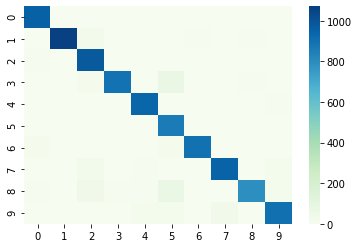

In [7]:
sns.heatmap(tf.math.confusion_matrix(y_test, y_hat.argmax(axis=1)  ), cmap='GnBu', cbar=True)

In [9]:
print(metrics.classification_report( y_test, y_hat.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.99      0.94      0.97      1135
           2       0.87      0.95      0.91      1032
           3       0.96      0.88      0.92      1010
           4       0.94      0.96      0.95       982
           5       0.81      0.97      0.88       892
           6       0.96      0.94      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.94      0.81      0.87       974
           9       0.93      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## CNN for CIFAR-10 Dataset

The CIFAR dataset is a complicated dataset with 10 classes of 6000 images in the respective classes. This is complicated in several aspects on of them being the RGB values in the input image. The pixel values without any inofrmation all has a greater pixel values unlike in MNIST dataset. The CIFAR dataset training was complicated because of the nature of the data. Generalisation techniques like Dropouts, Regularisation and Batch Normalisation were tried to achive better results and help the Network genralise better. Several, Networks of different sizes were tried starting with the shallow CNN used in for MNIST case.

According to the white paper listed below:
> *   https://arxiv.org/pdf/1603.05027.pdf
> *   https://keras.io/examples/cifar10_resnet/


the ResNets are indetified to perform better for the datasets. The filter sizes are doubled ofr every convoloutional layer as we progress from input layer to the output layer, meanwhile the strides are halved(downsampled). 



In [10]:
batch_size = 256  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

subtract_pixel_mean = True

n = 3
depth = n * 6 + 2

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
input_shape = x_train.shape[1:]

170500096/170498071 [==============================] - 11s 0us/step


The input data is normalised(the pixel values). By subtarcting the mean of the pixel values help us reach better accuracy.

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu',batch_normalization=True,conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

Here we build the 2D Convoultion layers - Batch Normalisation pairs. The method is taken from the above link and modified to the convinience. 

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  
                x = resnet_layer(inputs=x,num_filters=num_filters, kernel_size=1,strides=strides, activation=None, batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule(0)),metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 32, 32, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 32, 32, 16)   64          conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 32, 32, 16)   0           batch_normalization_96[0][0]     
______________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=1, save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [checkpoint, tensorboard_callback, lr_scheduler]

In [0]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [58]:
from google.colab import drive
drive.mount('/content/drive/')
model1 = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/CNN_resnet.hd5')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [59]:
print(model1.evaluate(x_test, y_test))
y_hat_1 = model1.predict(x_test)

10000/10000 [==============================] - 3s 301us/step
[0.49906386132240294, 0.9085000157356262]


In [60]:
print(metrics.classification_report(y_hat_1.argmax(axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1015
           1       0.97      0.95      0.96      1023
           2       0.86      0.87      0.87       990
           3       0.79      0.82      0.81       960
           4       0.92      0.90      0.91      1020
           5       0.84      0.87      0.85       966
           6       0.95      0.91      0.93      1045
           7       0.94      0.95      0.95       987
           8       0.95      0.96      0.95       990
           9       0.95      0.94      0.94      1004

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



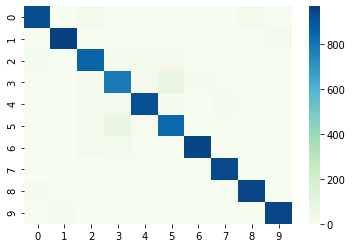

In [62]:
sns.heatmap(metrics.confusion_matrix(y_hat_1.argmax(axis=1), np.argmax(y_test, axis=1)), cmap = 'GnBu', cbar=True)

On training the NN model with image augmentation and for 200 epoch with varying learning rate. We observe the following behaviour.

![alt text](https://drive.google.com/uc?id=1-k3ROZNy8CBjJJupxN5Yp6Wnh4fKSmf_)

The plot shows the loss for validation and training against number of epochs.


![alt text](https://drive.google.com/uc?id=1-eMnMrI2l9PBcUxeZ0WZYP1-YV4EJmnq)

The plot shows the accuracy for the training and validation.

![alt text](https://drive.google.com/uc?id=1-e3Qd8kq1G4mOAsJrMkvEwFOo0npHdvg)

The figure shows the input image after normalisation and subtacting the pixel mean.

![alt text](https://drive.google.com/uc?id=1-Nq03zfZBZ0vsH61-F8wojF1jpxlqwQc)

The figure shows the varying learning rate across the epochs.

## CNN for CIFAR-100 Dataset

In [0]:
batch_size = 256  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 100

subtract_pixel_mean = True

n = 3
depth = n * 6 + 2

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
input_shape = x_train.shape[1:]

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar100_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [0]:
model_cifar100 = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/CNN_resnet_cifar100_2.hd5')

In [16]:
print(model_cifar100.evaluate(x_test, y_test))
y_hat_1 = model_cifar100.predict(x_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.6738 - accuracy: 0.6284
[1.6738015413284302, 0.6284000277519226]


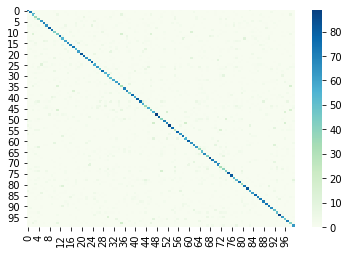

In [18]:
sns.heatmap(tf.math.confusion_matrix(np.argmax(y_hat_1, axis=1), np.argmax(y_test, axis=1) ), cmap='GnBu', cbar=True)

In [20]:
print(metrics.classification_report(y_hat_1.argmax(axis=1), np.argmax(y_test, axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80        81
           1       0.73      0.80      0.76        91
           2       0.52      0.58      0.55        89
           3       0.36      0.55      0.43        66
           4       0.43      0.51      0.47        84
           5       0.63      0.69      0.66        91
           6       0.71      0.66      0.69       107
           7       0.65      0.55      0.59       119
           8       0.82      0.71      0.76       115
           9       0.73      0.85      0.78        86
          10       0.43      0.43      0.43       101
          11       0.45      0.45      0.45       101
          12       0.75      0.61      0.67       123
          13       0.54      0.57      0.56        94
          14       0.60      0.47      0.53       127
          15       0.67      0.66      0.67       101
          16       0.68      0.65      0.66       105
          17       0.74    

The plot shows the loss for validation and training against number of epochs.

![alt text](https://drive.google.com/uc?id=1-t_oVS2ogocEas-vb_YyAo-C8N63aGNm)

The plot shows the accuracy for the training and validation.

![alt text](https://drive.google.com/uc?id=102-wDCf4fOLKXu6V8PbX1oD-wGdYs3av)

The figure shows the varying learning rate across the epochs.
![alt text](https://drive.google.com/uc?id=108UaqSKdTkoLLbt9r1_044KHJzNB1H6D)

The figure shows the input image after normalisation and subtacting the pixel mean.

![alt text](https://drive.google.com/uc?id=103bKsq8Xw0zVBNIE6FZFTPOyUcnmRIQS)


The model is the same as the above except for the last layer. The model was trained for 150 epochs. As the learning curves indicate, the model is still capable of learning and is not yet overfitting or underfitting. It can be trained further with number of epochs to achieve better results. The model still needs to fine tuned for the best results.

In [0]:
%tensorboard --logdir logs

## References:

$ @TECHREPORT { Krizhevsky09learningmultiple, author = {Alex Krizhevsky},
    title = {Learning multiple layers of features from tiny images},
    institution = {},
    year = {2009}} $